# M0 - Exploratory Data Analysis (EDA)
---
Group Number: 14
Student Names: Fanica Pedro, Fruttidoro Andrea, Weiss Quentin


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from scipy import stats
import imbalanced-learn as imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

class AutomatedEDA:
    """
    Fully automated exploratory data analysis and preprocessing class.

    This class detects column types, handles missing values, scales numeric data,
    detects outliers, performs normality checks, encodes categorical/binary variables,
    and provides optional imbalance reporting and resampling (SMOTE/undersampling).

    Attributes:
    -----------
    df : pd.DataFrame
        Original dataframe
    numeric_cols : list
        Detected numeric columns
    categorical_cols : list
        Detected categorical columns
    binary_cols : list
        Detected binary columns (0/1 or bool)
    """

    def __init__(self, df):
        """
        Initialize with a dataframe and automatically detect column types.
        """
        self.df = df.copy()
        self.detect_column_types()

    def _detect_column_types(self):
    """
    Identify numeric, binary, and categorical columns automatically.

    Rules:
    - Binary columns include:
        * Boolean dtype
        * Numeric with only {0,1}
        * Object/category with exactly 2 unique values
    - Numeric columns: all numeric columns not identified as binary
    - Categorical columns: object/category with > 2 unique values
    """
    # Start with numeric and categorical detection
    numeric_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
    object_cols = self.df.select_dtypes(include=['object', 'category']).columns.tolist()

    self.binary_cols = []
    self.numeric_cols = []
    self.categorical_cols = []

    # Check numeric columns for binary
    for col in numeric_cols:
        unique_vals = set(self.df[col].dropna().unique())
        if unique_vals.issubset({0, 1}):
            self.binary_cols.append(col)
        else:
            self.numeric_cols.append(col)

    # Check object/category columns
    for col in object_cols:
        unique_vals = self.df[col].dropna().unique()
        if len(unique_vals) == 2:  # treat as binary
            self.binary_cols.append(col)
        else:
            self.categorical_cols.append(col)

    # Add boolean dtype directly
    self.binary_cols += self.df.select_dtypes(include=['bool']).columns.tolist()

    # ------------------- Missing Value Handling -------------------
    def fill_missing(self, method_numeric='median', method_binary='mode', method_categorical='none', knn_cols=None, knn_neighbors=3):
        """
        Fill missing values in the dataset.
        - Numeric: median or mean
        - Binary: mode or KNN
        - Categorical: 'none' or mode
        - KNN: optionally impute multiple columns using KNN imputer
        """
        # Numeric
        for col in self.numeric_cols:
            if method_numeric == 'median':
                self.df[col] = self.df[col].fillna(self.df[col].median())
            elif method_numeric == 'mean':
                self.df[col] = self.df[col].fillna(self.df[col].mean())

        # Binary
        for col in self.binary_cols:
            if method_binary == 'mode':
                self.df[col] = self.df[col].fillna(self.df[col].mode()[0])

        # Categorical
        for col in self.categorical_cols:
            if method_categorical == 'none':
                self.df[col] = self.df[col].fillna('none')
            elif method_categorical == 'mode':
                self.df[col] = self.df[col].fillna(self.df[col].mode()[0])

        # KNN imputation
        if knn_cols:
            knn = KNNImputer(n_neighbors=knn_neighbors)
            self.df[knn_cols] = knn.fit_transform(self.df[knn_cols])

    # ------------------- Scaling -------------------
    def scale_numeric(self, method='minmax'):
        """Scale numeric columns using MinMax or Standard scaling."""
        if method == 'minmax':
            scaler = MinMaxScaler()
        elif method == 'standard':
            scaler = StandardScaler()
        else:
            raise ValueError("Scaling method must be 'minmax' or 'standard'")

        self.df[self.numeric_cols] = scaler.fit_transform(self.df[self.numeric_cols])

    # ------------------- Log Transform -------------------
    def log_transform(self, cols=None):
        """Apply log10 transform to specified numeric columns."""
        if cols is None:
            cols = self.numeric_cols
        for col in cols:
            self.df[col] = np.log10(self.df[col].replace(0, np.nan)).fillna(0)

    # ------------------- Outlier Detection -------------------
    def detect_outliers(self, method='zscore', threshold=3.0, plot=True):
        """
        Detect and optionally remove outliers.
        - method: 'zscore', 'iqr', 'qq'
        """
        outlier_report = []
        for col in self.numeric_cols:
            data = self.df[col]
            if method == 'zscore':
                mask = np.abs(stats.zscore(data, nan_policy='omit')) > threshold
            elif method == 'iqr':
                Q1, Q3 = np.percentile(data, [25, 75])
                IQR = Q3 - Q1
                mask = (data < Q1 - threshold*IQR) | (data > Q3 + threshold*IQR)
            elif method == 'qq':
                (osm, osr), _ = stats.probplot(data, dist="norm")
                mask = np.abs(osr - osm) > np.quantile(np.abs(osr - osm), 1 - (1/threshold))
            else:
                raise ValueError("Method must be 'zscore', 'iqr', or 'qq'")

            n_outliers = mask.sum()
            pct = n_outliers / len(data) * 100
            outlier_report.append([col, n_outliers, len(data), pct])

            # Drop outliers
            self.df = self.df.loc[~mask]

            if plot:
                fig, axs = plt.subplots(1, 2, figsize=(10, 4))
                sns.histplot(data, bins=30, ax=axs[0], kde=True)
                axs[0].set_title(f"{col} - Before (n={len(data)})")
                sns.histplot(self.df[col], bins=30, ax=axs[1], kde=True)
                axs[1].set_title(f"{col} - After (n={len(self.df[col])})")
                plt.show()

        return pd.DataFrame(outlier_report, columns=['Variable','Outliers Removed','Total','Percent Removed'])

    # ------------------- Normality Checks -------------------
    def check_normality(self):
        """Check normality of numeric columns: Shapiro-Wilk, D’Agostino K², skewness, kurtosis."""
        normality_results = []
        for col in self.numeric_cols:
            data = self.df[col].dropna()
            stat_sw, p_sw = stats.shapiro(data)
            stat_k2, p_k2 = stats.normaltest(data)
            skew = stats.skew(data)
            kurt = stats.kurtosis(data)
            normality_results.append([col, stat_sw, p_sw, stat_k2, p_k2, skew, kurt])
        return pd.DataFrame(normality_results,
                            columns=['Variable','Shapiro_Stat','Shapiro_p','Dagostino_Stat','Dagostino_p','Skewness','Kurtosis'])

    # ------------------- Encoding -------------------
    def encode_categorical(self, ordinal_mappings=None):
        """
        Encode categorical columns.
        - ordinal_mappings: dict like {'state': ['Early','Healthy','Advanced']}
        - Binary columns with string values are converted to 0/1
        - Remaining categorical columns are one-hot encoded
        """
        # Ordinal encoding
        if ordinal_mappings:
            for col, order in ordinal_mappings.items():
                enc = OrdinalEncoder(categories=[order])
                self.df[col] = enc.fit_transform(self.df[[col]])

        # Binary string to 0/1
        for col in self.binary_cols:
            if self.df[col].dtype == 'object':
                self.df[col] = self.df[col].map({self.df[col].unique()[0]:0,
                                                 self.df[col].unique()[1]:1})

        # One-hot encoding for remaining categoricals
        remaining = [col for col in self.categorical_cols if col not in (ordinal_mappings or {})]
        if remaining:
            self.df = pd.get_dummies(self.df, columns=remaining, drop_first=True)

    # ------------------- Imbalance Reporting -------------------
    def report_imbalance(self, target_cols=None, plot=True):
        """
        Report imbalance for binary/categorical columns.
        - target_cols: list of columns to check. If None, checks all binary + categorical columns
        """
        if target_cols is None:
            target_cols = self.binary_cols + self.categorical_cols
        imbalance_report = {}
        for col in target_cols:
            counts = self.df[col].value_counts()
            percentages = self.df[col].value_counts(normalize=True)*100
            imbalance_report[col] = pd.concat([counts, percentages], axis=1, keys=['Count','Percent'])

            if plot:
                sns.countplot(x=col, data=self.df)
                plt.title(f'Distribution of {col}')
                plt.show()
        return imbalance_report

    # ------------------- Optional SMOTE / Undersampling -------------------
    def resample(self, target_col, method='smote', sampling_strategy='not majority', random_state=42):
        """
        Resample dataset to handle imbalance.
        - method: 'smote' or 'undersample'
        - sampling_strategy: see imblearn documentation
        """
        X = self.df.drop(columns=target_col)
        y = self.df[target_col]

        if method == 'smote':
            sampler = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)
        elif method == 'undersample':
            sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=random_state)
        else:
            raise ValueError("method must be 'smote' or 'undersample'")

        X_res, y_res = sampler.fit_resample(X, y)
        self.df = pd.concat([X_res, y_res], axis=1)
        return self.df


In [ ]:
patients=pd.read_csv('/content/patients.csv',sep=';')
encounters=pd.read_csv('/content/encounters.csv',sep=';')
encounters['treatment']=encounters['treatment'].fillna('None')

encounters.head()

,patient_id,time,state,treatment,chest_pain,fatigue,shortness_of_breath,systolic_bp,cholesterol,glucose,troponin,utility
0,1,0,Early,DrugA,1.0,1.0,0.0,113.68,NaN,88.58,NaN,0.449
1,1,1,Early,Lifestyle,0.0,NaN,0.0,130.60,226.68,112.56,0.0139,0.471
2,1,2,Early,None,NaN,0.0,0.0,165.78,146.18,95.92,0.0234,0.474
3,1,3,Early,DrugA,0.0,1.0,0.0,NaN,179.56,108.17,0.0141,0.450
4,1,4,Early,DrugA,NaN,0.0,0.0,143.03,NaN,NaN,0.0033,0.447


In [ ]:
patients.head()

,patient_id,age,sex,bmi,smoker,family_history,hypertension,risk_score,initial_state
0,1,61,M,26.05,0,0,0,1,Early
1,2,53,M,19.51,1,0,1,3,Healthy
2,3,63,F,33.82,1,0,0,3,Healthy
3,4,73,M,25.48,1,0,0,2,Healthy
4,5,52,F,24.56,0,0,0,1,Healthy


## 1. Dataset Overview

In [ ]:
# How many patients:
num_patients = patients["patient_id"].nunique()

# How many encounters in total:
num_encounters = encounters.shape[0]

# How many encounters per patient on average:
encounters_per_patient = (
    encounters.groupby("patient_id").size().mean()
)

print(f"Number of patients: {num_patients}")
print(f"Total number of encounters: {num_encounters}")
print(f"Encounters per patient on average: {encounters_per_patient:.2f}")


Number of patients: 3000
Total number of encounters: 24000
Encounters per patient on average: 8.00


With 3,000 patients, the sample size is substantial and the ratio of encounters to patients is exactly 8.00, indicating a longitudinally balanced dataset.

On average, each patient has had 8 encounters recorded over time. This suggests the dataset is well-suited for studying disease progression and treatment efficacy over time, as the history is consistently sampled for each individual.

## 2. Baseline Characteristics


###2.1 For patients.csv

In [ ]:
patients.describe()

,patient_id,age,bmi,smoker,family_history,hypertension,risk_score
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,55.370667,26.944790,0.281333,0.259333,0.367667,1.848667
std,866.169729,11.809026,5.115749,0.449725,0.438342,0.482250,1.035755
min,1.000000,18.000000,16.000000,0.000000,0.000000,0.000000,0.000000
25%,750.750000,47.000000,23.400000,0.000000,0.000000,0.000000,1.000000
50%,1500.500000,55.000000,26.835000,0.000000,0.000000,0.000000,2.000000
75%,2250.250000,63.000000,30.490000,1.000000,1.000000,1.000000,3.000000
max,3000.000000,90.000000,44.650000,1.000000,1.000000,1.000000,5.000000


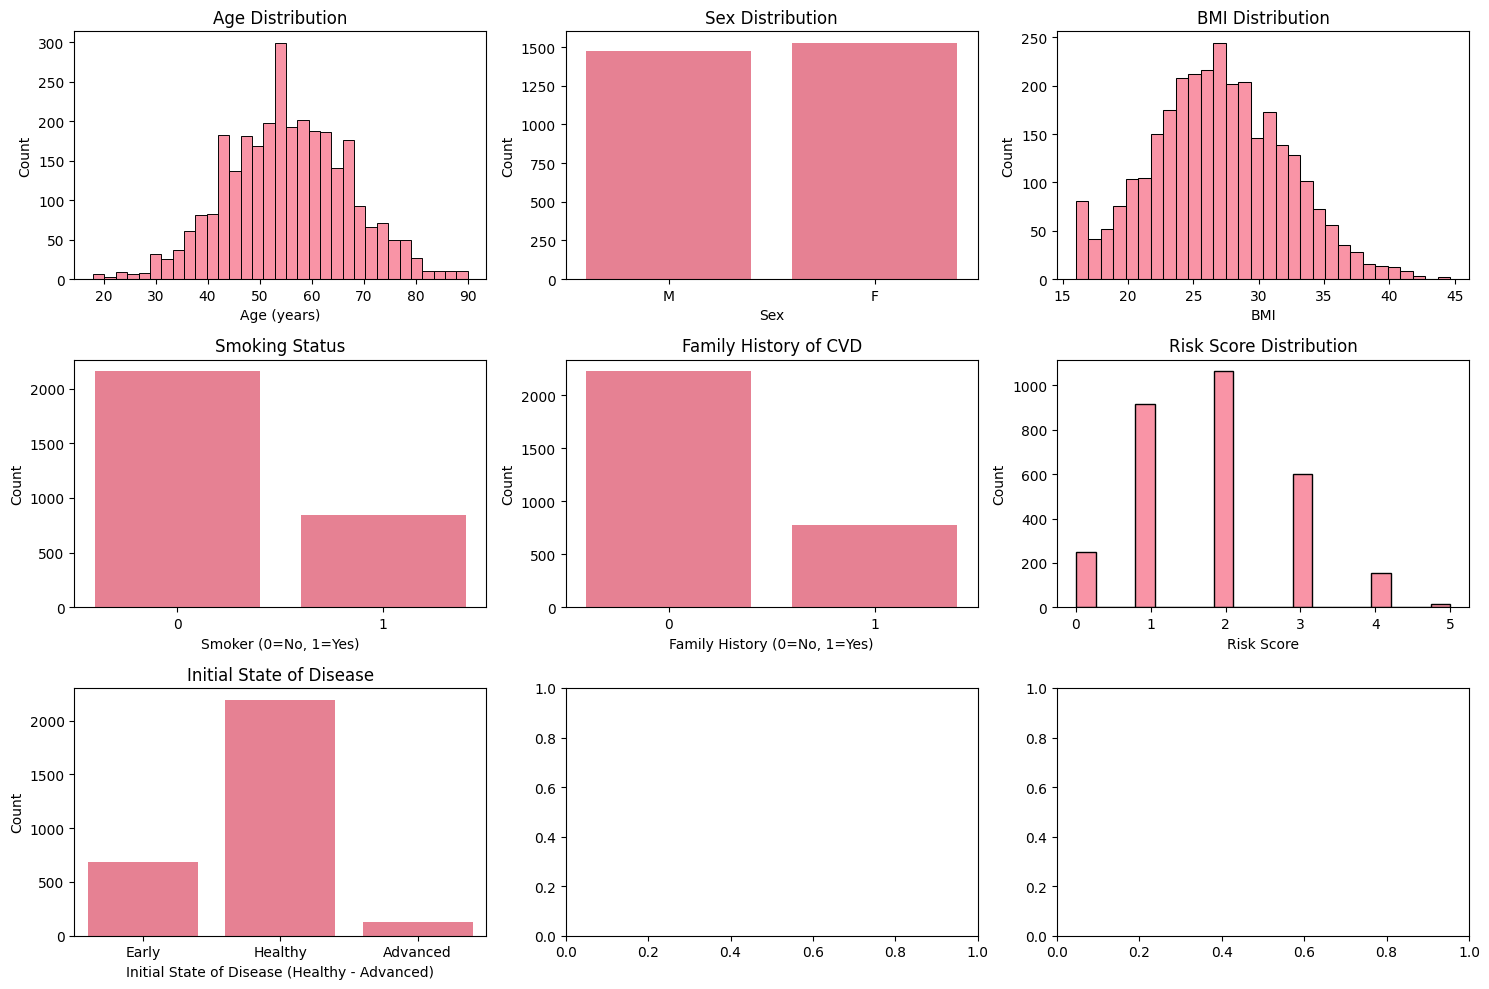

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# Age distribution
sns.histplot(patients['age'], ax=axs[0, 0])
axs[0, 0].set_title('Age Distribution')
axs[0, 0].set_xlabel('Age (years)')
axs[0, 0].set_ylabel('Count')

# Sex distribution
sns.countplot(x='sex', data=patients, ax=axs[0, 1])
axs[0, 1].set_title('Sex Distribution')
axs[0, 1].set_xlabel('Sex')
axs[0, 1].set_ylabel('Count')

# BMI distribution
sns.histplot(patients['bmi'], ax=axs[0, 2])
axs[0, 2].set_title('BMI Distribution')
axs[0, 2].set_xlabel('BMI')
axs[0, 2].set_ylabel('Count')

# Smoking status
sns.countplot(x='smoker', data=patients, ax=axs[1, 0])
axs[1, 0].set_title('Smoking Status')
axs[1, 0].set_xlabel('Smoker (0=No, 1=Yes)')
axs[1, 0].set_ylabel('Count')

# Family history
sns.countplot(x='family_history', data=patients, ax=axs[1, 1])
axs[1, 1].set_title('Family History of CVD')
axs[1, 1].set_xlabel('Family History (0=No, 1=Yes)')
axs[1, 1].set_ylabel('Count')

# Risk score
sns.histplot(patients['risk_score'], ax=axs[1, 2])
axs[1, 2].set_title('Risk Score Distribution')
axs[1, 2].set_xlabel('Risk Score')
axs[1, 2].set_ylabel('Count')

# Initial State
sns.countplot(x='initial_state', data=patients, ax=axs[2, 0])
axs[2, 0].set_title('Initial State of Disease')
axs[2, 0].set_xlabel('Initial State of Disease (Healthy - Advanced)')
axs[2, 0].set_ylabel('Count')


plt.tight_layout()
plt.show()


### Observations:
At least 3 features are imbalanced (initial_state, smoking_status and family_history).

Sex is very well distributed in our data, which is good to infer if sex has any correlation with the desease or treatment, while age, bmi and risk_score are features that more or less follow a normal distribution.

The dataset consists of patients equally distributed by sex; 28% are identified as smokers, and 25% report a family history of cardiovascular disease in first-degree relatives.

The age range considered in the dataset is relatively broad, spanning from 18 to 90 years.

Regarding the risk score, descriptive statistics indicate a mean value of 1.85 (SD = 1.04). The distribution ranges from 0 to 5, with quartiles at 1, 2 and 3, suggesting a concentration of patients in the low-to-moderate risk categories.

###2.2 For encounters.csv

Now let's see also how the encounters dataset's features are distributed.

In [ ]:
encounters.describe()

,patient_id,time,chest_pain,fatigue,shortness_of_breath,systolic_bp,cholesterol,glucose,troponin,utility
count,24000.000000,24000.000000,22103.000000,22114.000000,22067.000000,22133.000000,22046.000000,22034.000000,22040.000000,24000.000000
mean,1500.500000,3.500000,0.124644,0.190920,0.114606,127.939647,201.730388,100.240112,0.008594,0.759256
std,866.043398,2.291336,0.330322,0.393035,0.318552,15.293780,40.962376,15.529028,0.007510,0.319416
min,1.000000,0.000000,0.000000,0.000000,0.000000,79.280000,33.700000,48.590000,0.000000,-0.202000
25%,750.750000,1.750000,0.000000,0.000000,0.000000,117.400000,173.620000,89.570000,0.003900,0.444000
50%,1500.500000,3.500000,0.000000,0.000000,0.000000,126.780000,200.335000,99.070000,0.006600,0.982000
75%,2250.250000,5.250000,0.000000,0.000000,0.000000,137.330000,228.347500,109.630000,0.010800,1.000000
max,3000.000000,7.000000,1.000000,1.000000,1.000000,207.470000,391.960000,181.350000,0.069300,1.000000


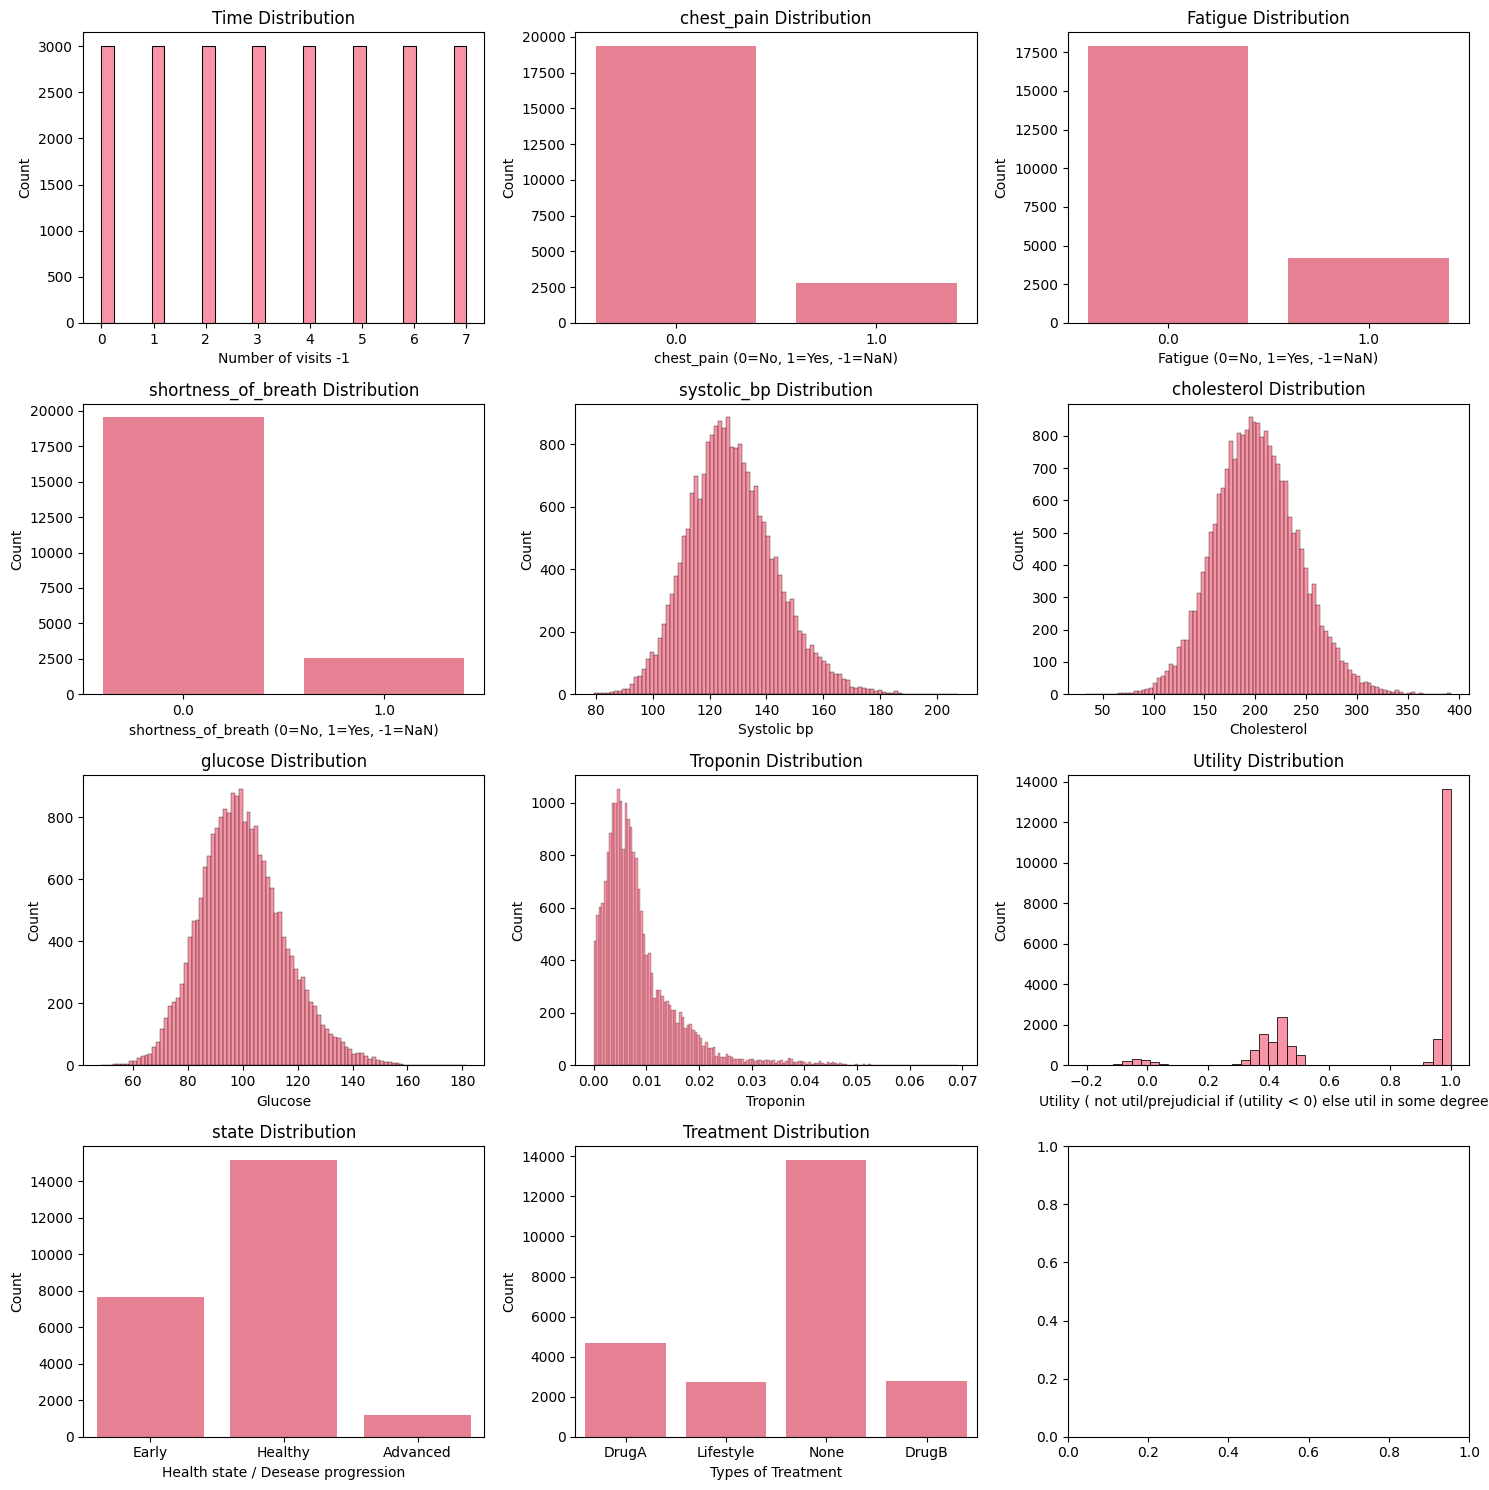

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(15, 15))

# Time distribution
sns.histplot(encounters['time'], ax=axs[0, 0])
axs[0, 0].set_title('Time Distribution')
axs[0, 0].set_xlabel('Number of visits -1')
axs[0, 0].set_ylabel('Count')

# chest_pain distribution
sns.countplot(x='chest_pain', data=encounters, ax=axs[0, 1])
axs[0, 1].set_title('chest_pain Distribution')
axs[0, 1].set_xlabel('chest_pain (0=No, 1=Yes, -1=NaN)')
axs[0, 1].set_ylabel('Count')

# fatigue distribution
sns.countplot(x='fatigue', data=encounters, ax=axs[0, 2])
axs[0, 2].set_title('Fatigue Distribution')
axs[0, 2].set_xlabel('Fatigue (0=No, 1=Yes, -1=NaN)')
axs[0, 2].set_ylabel('Count')

# shortness_of_breath status
sns.countplot(x='shortness_of_breath', data=encounters, ax=axs[1, 0])
axs[1, 0].set_title('shortness_of_breath Distribution')
axs[1, 0].set_xlabel('shortness_of_breath (0=No, 1=Yes, -1=NaN)')
axs[1, 0].set_ylabel('Count')

# systolic_bp history
sns.histplot(encounters['systolic_bp'], ax=axs[1, 1])
axs[1, 1].set_title('systolic_bp Distribution')
axs[1, 1].set_xlabel('Systolic bp')
axs[1, 1].set_ylabel('Count')

# cholesterol
sns.histplot(encounters['cholesterol'], ax=axs[1, 2])
axs[1, 2].set_title('cholesterol Distribution')
axs[1, 2].set_xlabel('Cholesterol')
axs[1, 2].set_ylabel('Count')

# glucose
sns.histplot(encounters['glucose'], ax=axs[2, 0])
axs[2, 0].set_title('glucose Distribution')
axs[2, 0].set_xlabel('Glucose')
axs[2, 0].set_ylabel('Count')

# troponin
sns.histplot(encounters['troponin'], ax=axs[2, 1])
axs[2, 1].set_title('Troponin Distribution')
axs[2, 1].set_xlabel('Troponin')
axs[2, 1].set_ylabel('Count')

# utility
sns.histplot(encounters['utility'], bins=40, ax=axs[2, 2])
axs[2, 2].set_title('Utility Distribution')
axs[2, 2].set_xlabel('Utility ( not util/prejudicial if (utility < 0) else util in some degree )')
axs[2, 2].set_ylabel('Count')

# state
sns.countplot(x='state', data=encounters, ax=axs[3, 0])
axs[3, 0].set_title('state Distribution')
axs[3, 0].set_xlabel('Health state / Desease progression')
axs[3, 0].set_ylabel('Count')

# treatment
sns.countplot(x='treatment', data=encounters, ax=axs[3, 1])
axs[3, 1].set_title('Treatment Distribution')
axs[3, 1].set_xlabel('Types of Treatment')
axs[3, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

The visits over time are balanced, with no evidence of dropouts.

Most patients report no symptoms, indicating that chest pain, fatigue, and shortness of breath are rare in this cohort.

Blood pressure and cholesterol values are generally within normal ranges, while glucose shows a few higher values, suggesting possible diabetic cases. Troponin is mostly near zero, as expected.

Utility is heavily concentrated near 1, showing that most patients are in a healthy state. Most patients are classified as Healthy, with fewer in Early and very few in Advanced stages.

In terms of treatment, most encounters involve no intervention, while DrugA, DrugB, and Lifestyle are used only occasionally, reflecting the overall good health of the cohort.

###2.3 Test the normality distribution of the variables

In [ ]:
auto_enc=AutomatedEDA(encounters)
display(auto_enc.df.head())
display("Binary features:", auto_enc.binary_cols)
display("Categorical features:", auto_enc.categorical_cols)
display("Numeric features:", auto_enc.numeric_cols)
auto_pat=AutomatedEDA(patients)
display(auto_pat.df.head())
display("Binary features:", auto_pat.binary_cols)
display("Categorical features:", auto_pat.categorical_cols)
display("Numeric features:", auto_pat.numeric_cols)

,patient_id,time,state,treatment,chest_pain,fatigue,shortness_of_breath,systolic_bp,cholesterol,glucose,troponin,utility
0,1,0,Early,DrugA,1.0,1.0,0.0,113.68,NaN,88.58,NaN,0.449
1,1,1,Early,Lifestyle,0.0,NaN,0.0,130.60,226.68,112.56,0.0139,0.471
2,1,2,Early,None,NaN,0.0,0.0,165.78,146.18,95.92,0.0234,0.474
3,1,3,Early,DrugA,0.0,1.0,0.0,NaN,179.56,108.17,0.0141,0.450
4,1,4,Early,DrugA,NaN,0.0,0.0,143.03,NaN,NaN,0.0033,0.447


'Binary features:'

['chest_pain', 'fatigue', 'shortness_of_breath']

'Categorical features:'

['state', 'treatment']

'Numeric features:'

['patient_id',
 'time',
 'systolic_bp',
 'cholesterol',
 'glucose',
 'troponin',
 'utility']

,patient_id,age,sex,bmi,smoker,family_history,hypertension,risk_score,initial_state
0,1,61,M,26.05,0,0,0,1,Early
1,2,53,M,19.51,1,0,1,3,Healthy
2,3,63,F,33.82,1,0,0,3,Healthy
3,4,73,M,25.48,1,0,0,2,Healthy
4,5,52,F,24.56,0,0,0,1,Healthy


'Binary features:'

['smoker', 'family_history', 'hypertension', 'sex']

'Categorical features:'

['initial_state']

'Numeric features:'

['patient_id', 'age', 'bmi', 'risk_score']

Scaling the numeric columns using the function defined below:

In [ ]:
    # ------------------- Scaling -------------------
    def scale_numeric(self, method='minmax'):
        """Scale numeric columns using MinMax or Standard scaling."""
        if method == 'minmax':
            scaler = MinMaxScaler()
        elif method == 'standard':
            scaler = StandardScaler()
        else:
            raise ValueError("Scaling method must be 'minmax' or 'standard'")

        self.df[self.numeric_cols] = scaler.fit_transform(self.df[self.numeric_cols])

In [ ]:
scaled_encounters=auto_enc.scale_numeric()
sclaed_patients=auto_pat.scale_numeric()

To perform a comprehensive normality assessment a new function is defined, which calculates and returns a summary dataframe containing the following for each numeric variable:

* Shapiro-Wilk Test: (the test statistic and p-value);

* D'Agostino-Pearson test (the test statistic and p-value);

* Skewness: A measure of the asymmetry of the distribution.

* Kurtosis: A measure of the "tailedness" and peakedness of the distribution.

In [ ]:
    # ------------------- Normality Checks -------------------
    def check_normality(self):
        """Check normality of numeric columns: Shapiro-Wilk, D’Agostino K², skewness, kurtosis."""
        normality_results = []
        for col in self.numeric_cols:
            data = self.df[col].dropna()
            stat_sw, p_sw = stats.shapiro(data)
            stat_k2, p_k2 = stats.normaltest(data)
            skew = stats.skew(data)
            kurt = stats.kurtosis(data)
            normality_results.append([col, stat_sw, p_sw, stat_k2, p_k2, skew, kurt])
        return pd.DataFrame(normality_results,
                            columns=['Variable','Shapiro_Stat','Shapiro_p','Dagostino_Stat','Dagostino_p','Skewness','Kurtosis'])

In [ ]:
normality_scaled_encounters=auto_enc.check_normality()
normality_scaled_patients=auto_pat.check_normality()
display(normality_scaled_encounters)
display(normality_scaled_patients)

,Variable,Shapiro_Stat,Shapiro_p,Dagostino_Stat,Dagostino_p,Skewness,Kurtosis
0,patient_id,0.954927,9.929910e-64,21133.028218,0.000000e+00,-2.950718e-16,-1.200000
1,time,0.925758,3.939642e-74,31416.535601,0.000000e+00,2.954624e-17,-1.238095
2,systolic_bp,0.991246,3.694518e-34,629.919035,1.639908e-137,4.000144e-01,0.345591
3,cholesterol,0.997299,2.553258e-19,201.844969,1.478842e-44,2.178120e-01,0.202251
4,glucose,0.989697,1.695466e-36,751.584490,6.244556e-164,4.347347e-01,0.423943
5,troponin,0.797418,1.995907e-95,10764.873670,0.000000e+00,2.291268e+00,7.456276
6,utility,0.719810,9.643798e-106,2890.064476,0.000000e+00,-9.052924e-01,-0.496202


,Variable,Shapiro_Stat,Shapiro_p,Dagostino_Stat,Dagostino_p,Skewness,Kurtosis
0,patient_id,0.954888,1.651572e-29,2487.955097,0.000000e+00,-5.901437e-16,-1.200000
1,age,0.998724,2.183425e-02,0.201359,9.042228e-01,1.772291e-02,-0.024248
2,bmi,0.995448,5.793291e-08,15.569086,4.161175e-04,1.383700e-01,-0.202027
3,risk_score,0.913780,2.556348e-38,43.227174,4.105239e-10,2.548339e-01,-0.267421


Focusing on the patients' variables (age and bmi):

1. Age

The Shapiro-Wilk test (p-value of 0.0218) suggests a rejection of the null hypothesis (that the data is normal) at the standard α=0.05 level. However, the D'Agostino-Pearson test has a high p-value (0.904), strongly indicating that the data is consistent with a normal distribution.

The Skewness (0.0177) is extremely close to zero, and the Kurtosis (−0.0242) is very close to zero.

Hence, Given the descriptive statistics and the D'Agostino-Pearson test result, the Age distribution is very close to a normal distribution. The distribution is highly symmetrical and not peaked or flat.

Despite the two tests reaching different conclusions regarding normality, we will rely more heavily on the D'Agostino-Pearson test due to the large sample size.

2. BMI (Body Mass Index)

Both the Shapiro-Wilk (p`≪`0.001) and D'Agostino-Pearson (p`<`0.001) tests strongly reject the null hypothesis of normality.

The Skewness (0.1384) is positive but small, indicating a slight right-tail. The Kurtosis (−0.2020) is negative, suggesting the distribution is slightly flatter than a perfect normal curve.

We can conclude that the BMI distribution is not strictly normal.

##3 Disease states

###3.1 Proportion of encounters in each disease state

In [ ]:
state_counts = encounters["state"].value_counts(normalize=True) * 100
print("Proportion of encounters per state (%):")
print(state_counts)

import pandas as pd
import numpy as np

encounters_num_state = encounters.copy()
# Map state to numeric values
state_map = {"Healthy": 0, "Early": -1, "Advanced": -2}
encounters_num_state["state_num"] = encounters_num_state["state"].map(state_map)

# Function to compute progression features per patient
def compute_progression_patient(group):
    encounters = group.sort_values("time")["state_num"].values
    times = group.sort_values("time")["time"].values

    diff = np.diff(encounters)
    slope = np.polyfit(times, encounters, 1)[0]  # trend over time
    cumulative_change = diff.sum()

    return pd.Series({
        "avg_change": diff.mean() if len(diff) > 0 else 0,
        "slope": slope,
        "cumulative_change": cumulative_change,
        "first_state": encounters[0],
        "last_state": encounters[-1]
    })

# Apply per patient
patient_prog = (
    encounters_num_state
    .groupby("patient_id")
    .apply(compute_progression_patient, include_groups=False)
    .reset_index()
)
patient_prog


Proportion of encounters per state (%):
state
Healthy     63.212500
Early       31.895833
Advanced     4.891667
Name: proportion, dtype: float64


,patient_id,avg_change,slope,cumulative_change,first_state,last_state
0,1,0.000000,-1.099298e-17,0.0,-1.0,-1.0
1,2,-0.142857,-1.785714e-01,-1.0,0.0,-1.0
2,3,0.000000,0.000000e+00,0.0,0.0,0.0
3,4,0.000000,0.000000e+00,0.0,0.0,0.0
4,5,0.000000,0.000000e+00,0.0,0.0,0.0
...,...,...,...,...,...,...
2995,2996,0.000000,-2.198596e-17,0.0,-2.0,-2.0
2996,2997,0.000000,0.000000e+00,0.0,0.0,0.0
2997,2998,0.142857,1.785714e-01,1.0,-1.0,0.0
2998,2999,-0.142857,-1.428571e-01,-1.0,0.0,-1.0


These results calculate the longitudinal progression over time for each of the 3,000 patients, based on the numerical mapping of health states: Healthy (0), Early (−1), Advanced (−2).
The vast majority of encounters (over 95%) involve patients in the Healthy or Early stages, with a clear dominance of healthy individuals. Encounters involving patients in the Advanced state are relatively rare.


###3.2 Health progression over time

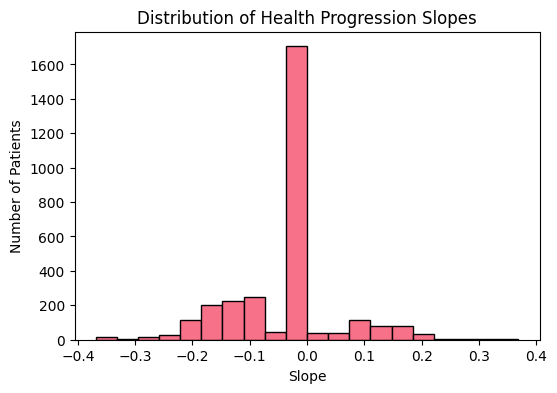

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(patient_prog["slope"], bins=20, edgecolor='black')
plt.title("Distribution of Health Progression Slopes")
plt.xlabel("Slope")
plt.ylabel("Number of Patients")
plt.show()


The histogram shows the number of patients based on the slope value, which represents the change in their health status over time.

A negative slope indicates worsening health over time.

A positive slope indicates improving health (or a slowing down of decline).

A slope near zero indicates a stable health status.

* Predominant Stability: The most striking feature is a very tall, narrow bar centered around a slope of 0. This peak, representing over 1,600 patients, indicates that the majority of individuals have relatively stable health or very slow progression over the observation period.

* Negative Slopes (Worsening): A significant number of patients (around 200–250 per bar) have slopes between −0.2 and −0.05. This suggests a subgroup of patients who tend to get worse over time.

* Positive Slopes (Improvement): Patients with positive slopes are fewer compared to the stable or worsening groups. Most of those experiencing improve have slopes between 0.05 and 0.2.

* Extremes: Very few patients show extreme slopes (close to ±0.4), indicating that rapid or large changes in health, whether positive or negative, are uncommon.



In [ ]:
# Sort by slope to find extremes
stable_patients = patient_prog[np.isclose(patient_prog["slope"], 0)]
declining_patients = patient_prog[patient_prog["slope"] < -0.05]  # arbitrary threshold
improving_patients = patient_prog[patient_prog["slope"] > 0.05]   # arbitrary threshold

# Show a few examples
print("Stable patients:")
print(stable_patients.head(3))

print("\nDeclining patients:")
print(declining_patients.head(3))

print("\nImproving patients:")
print(improving_patients.head(3))


Stable patients:
   patient_id  avg_change         slope  cumulative_change  first_state  \
0           1         0.0 -1.099298e-17                0.0         -1.0   
2           3         0.0  0.000000e+00                0.0          0.0   
3           4         0.0  0.000000e+00                0.0          0.0   

   last_state  
0        -1.0  
2         0.0  
3         0.0  

Declining patients:
   patient_id  avg_change     slope  cumulative_change  first_state  \
1           2   -0.142857 -0.178571               -1.0          0.0   
8           9   -0.142857 -0.142857               -1.0          0.0   
9          10   -0.142857 -0.083333               -1.0          0.0   

   last_state  
1        -1.0  
8        -1.0  
9        -1.0  

Improving patients:
    patient_id  avg_change     slope  cumulative_change  first_state  \
12          13    0.142857  0.083333                1.0         -1.0   
13          14    0.142857  0.083333                1.0         -1.0   
14         

##4 Symptoms and laboratory values


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal, chi2_contingency
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# Load the datasets
encounters_df = pd.read_csv('encounters.csv', sep=';')
encounters_df['treatment'] = encounters_df['treatment'].fillna('None')

print(f"Encounters data loaded: {encounters_df.shape[0]} rows")
print("="*60)

# OVERALL FREQUENCIES AND STATISTICS

print("\nBINARY SYMPTOMS - OVERALL FREQUENCIES:")
print("-" * 40)
binary_symptoms = ['chest_pain', 'fatigue', 'shortness_of_breath']

symptom_freq = {}
for symptom in binary_symptoms:
    positive_count = (int)(encounters_df[symptom].sum())
    total_count = len(encounters_df)
    percentage = (positive_count / total_count) * 100
    symptom_freq[symptom] = {'count': positive_count, 'percentage': percentage}
    symptom_name = symptom.replace('_', ' ').title()
    print(f"  {symptom_name:25s}: {positive_count:5d}/{total_count:5d} ({percentage:5.1f}%)")

print("\n\nLABORATORY VALUES - DESCRIPTIVE STATISTICS:")
print("-" * 40)
lab_values = ['systolic_bp', 'cholesterol', 'glucose', 'troponin']

lab_stats = {}
for lab in lab_values:
    stats_dict = encounters_df[lab].describe()
    lab_stats[lab] = stats_dict
    lab_name = lab.replace('_', ' ').title()
    print(f"\n{lab_name}:")
    print(f"  Mean:   {stats_dict['mean']:8.2f}")
    print(f"  Median: {stats_dict['50%']:8.2f}")
    print(f"  Std:    {stats_dict['std']:8.2f}")
    print(f"  Range:  {stats_dict['min']:8.2f} - {stats_dict['max']:8.2f}")




Encounters data loaded: 24000 rows

BINARY SYMPTOMS - OVERALL FREQUENCIES:
----------------------------------------
  Chest Pain               :  2755/24000 ( 11.5%)
  Fatigue                  :  4222/24000 ( 17.6%)
  Shortness Of Breath      :  2529/24000 ( 10.5%)


LABORATORY VALUES - DESCRIPTIVE STATISTICS:
----------------------------------------

Systolic Bp:
  Mean:     127.94
  Median:   126.78
  Std:       15.29
  Range:     79.28 -   207.47

Cholesterol:
  Mean:     201.73
  Median:   200.33
  Std:       40.96
  Range:     33.70 -   391.96

Glucose:
  Mean:     100.24
  Median:    99.07
  Std:       15.53
  Range:     48.59 -   181.35

Troponin:
  Mean:       0.01
  Median:     0.01
  Std:        0.01
  Range:      0.00 -     0.07


Across 24,000 encounters, cardiovascular symptoms show moderate prevalence: fatigue is most common (17.6%), followed by chest pain (11.5%) and shortness of breath (10.5%). Laboratory values reveal a population with elevated cardiovascular risk, with mean systolic BP of 128 mmHg, cholesterol at 202 mg/dL, and glucose at 100 mg/dL—all bordering clinical thresholds. Notably, troponin levels (mean 0.01 ng/mL) remain low on average but show variability, suggesting intermittent cardiac stress events across the cohort.

In [ ]:
# ANALYSIS BY DISEASE STATE

disease_states = ['Advanced', 'Early', 'Healthy']

# Count encounters per state
state_counts = encounters_df['state'].value_counts()
print("\nEncounters per disease state:")
for state in disease_states:
    count = state_counts[state]
    percentage = (count / len(encounters_df)) * 100
    print(f"  {state:20s}: {count:5d} ({percentage:5.1f}%)")

# Symptoms by disease state
print("\n\nSYMPTOMS BY DISEASE STATE:")
print("-" * 60)
for symptom in binary_symptoms:
    symptom_name = symptom.replace('_', ' ').title()
    print(f"\n{symptom_name}:")
    print(f"  {'State':20s} {'Positive':>10s} {'Total':>10s} {'Prevalence':>12s}")
    print("  " + "-"*56)
    for state in disease_states:
        state_data = encounters_df[encounters_df['state'] == state]
        positive = (int)(state_data[symptom].sum())
        total = len(state_data)
        percentage = (positive / total) * 100 if total > 0 else 0
        print(f"  {state:20s} {positive:10d} {total:10d} {percentage:11.1f}%")

# Lab values by disease state
print("\n\nLABORATORY VALUES BY DISEASE STATE:")
print("-" * 60)
for lab in lab_values:
    lab_name = lab.replace('_', ' ').title()
    print(f"\n{lab_name}:")
    print(f"  {'State':20s} {'Mean':>10s} {'Median':>10s} {'Std Dev':>10s}")
    print("  " + "-"*55)

    for state in disease_states:
        state_data = encounters_df[encounters_df['state'] == state][lab]
        mean_val = state_data.mean()
        median_val = state_data.median()
        std_val = state_data.std()
        print(f"  {state:20s} {mean_val:10.2f} {median_val:10.2f} {std_val:10.2f}")


Encounters per disease state:
  Advanced            :  1174 (  4.9%)
  Early               :  7655 ( 31.9%)
  Healthy             : 15171 ( 63.2%)


SYMPTOMS BY DISEASE STATE:
------------------------------------------------------------

Chest Pain:
  State                  Positive      Total   Prevalence
  --------------------------------------------------------
  Advanced                    535       1174        45.6%
  Early                      1526       7655        19.9%
  Healthy                     694      15171         4.6%

Fatigue:
  State                  Positive      Total   Prevalence
  --------------------------------------------------------
  Advanced                    688       1174        58.6%
  Early                      2148       7655        28.1%
  Healthy                    1386      15171         9.1%

Shortness Of Breath:
  State                  Positive      Total   Prevalence
  --------------------------------------------------------
  Advanced        

Here's a summary:
"The majority of encounters (63.2%) represent healthy patients, with 31.9% in early disease and only 4.9% in advanced disease stages.
Both symptoms and laboratory values show clear monotonic progression across disease states.
Symptom prevalence increases dramatically from healthy to advanced disease: chest pain (4.6% → 19.9% → 45.6%), fatigue (9.1% → 28.1% → 58.6%), and shortness of breath (3.4% → 18.2% → 52.6%). Similarly, all biomarkers worsen with disease progression: systolic BP rises from 122 to 151 mmHg, cholesterol from 190 to 243 mg/dL, glucose from 95 to 118 mg/dL, and troponin triples from 0.01 to 0.03 ng/mL. This systematic gradient validates the disease state classification and demonstrates that observable clinical variables effectively discriminate between latent health states

In [ ]:
# STATISTICAL SIGNIFICANCE TESTS

print("Testing if symptoms/labs differ significantly across disease states\n")

# Chi-square tests for binary symptoms
print("Binary Symptoms (Chi-square test):")
print("-" * 60)
for symptom in binary_symptoms:
    contingency_table = pd.crosstab(encounters_df['state'], encounters_df[symptom])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    symptom_name = symptom.replace('_', ' ').title()
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"  {symptom_name:25s}: chi2 = {chi2:8.2f}, p = {p_value:.6f} {significance}")

# Kruskal-Wallis tests for continuous lab values
print("\nLaboratory Values (Kruskal-Wallis test):")
print("-" * 60)
for lab in lab_values:
    groups = [encounters_df[encounters_df['state'] == state][lab].dropna().values
              for state in disease_states]
    # Filter out empty groups
    groups = [g for g in groups if len(g) > 0]
    if len(groups) >= 2:
        h_stat, p_value = kruskal(*groups)
    else:
        h_stat, p_value = np.nan, np.nan
    lab_name = lab.replace('_', ' ').title()
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"  {lab_name:25s}: H = {h_stat:8.2f}, p = {p_value:.6f} {significance}")

print("\nSignificance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")


Testing if symptoms/labs differ significantly across disease states

Binary Symptoms (Chi-square test):
------------------------------------------------------------
  Chest Pain               : chi2 =  2628.96, p = 0.000000 ***
  Fatigue                  : chi2 =  2718.09, p = 0.000000 ***
  Shortness Of Breath      : chi2 =  3520.59, p = 0.000000 ***

Laboratory Values (Kruskal-Wallis test):
------------------------------------------------------------
  Systolic Bp              : H =  5851.88, p = 0.000000 ***
  Cholesterol              : H =  3396.81, p = 0.000000 ***
  Glucose                  : H =  4141.08, p = 0.000000 ***
  Troponin                 : H =  9227.64, p = 0.000000 ***

Significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant


Statistical testing confirms that all symptoms and laboratory values differ highly significantly across disease states (all p < 0.001). Chi-square tests reveal strong associations between disease state and symptom presence, with shortness of breath showing the strongest effect (χ² = 3521). Kruskal-Wallis tests for continuous biomarkers yield exceptionally high test statistics, with troponin demonstrating the most pronounced differences across states (H = 9228), followed by systolic blood pressure (H = 5852). These results provide robust statistical evidence that observable clinical variables are reliable indicators of the underlying disease state, supporting their use as emission probabilities in Hidden Markov Models and as predictor variables in Bayesian networks

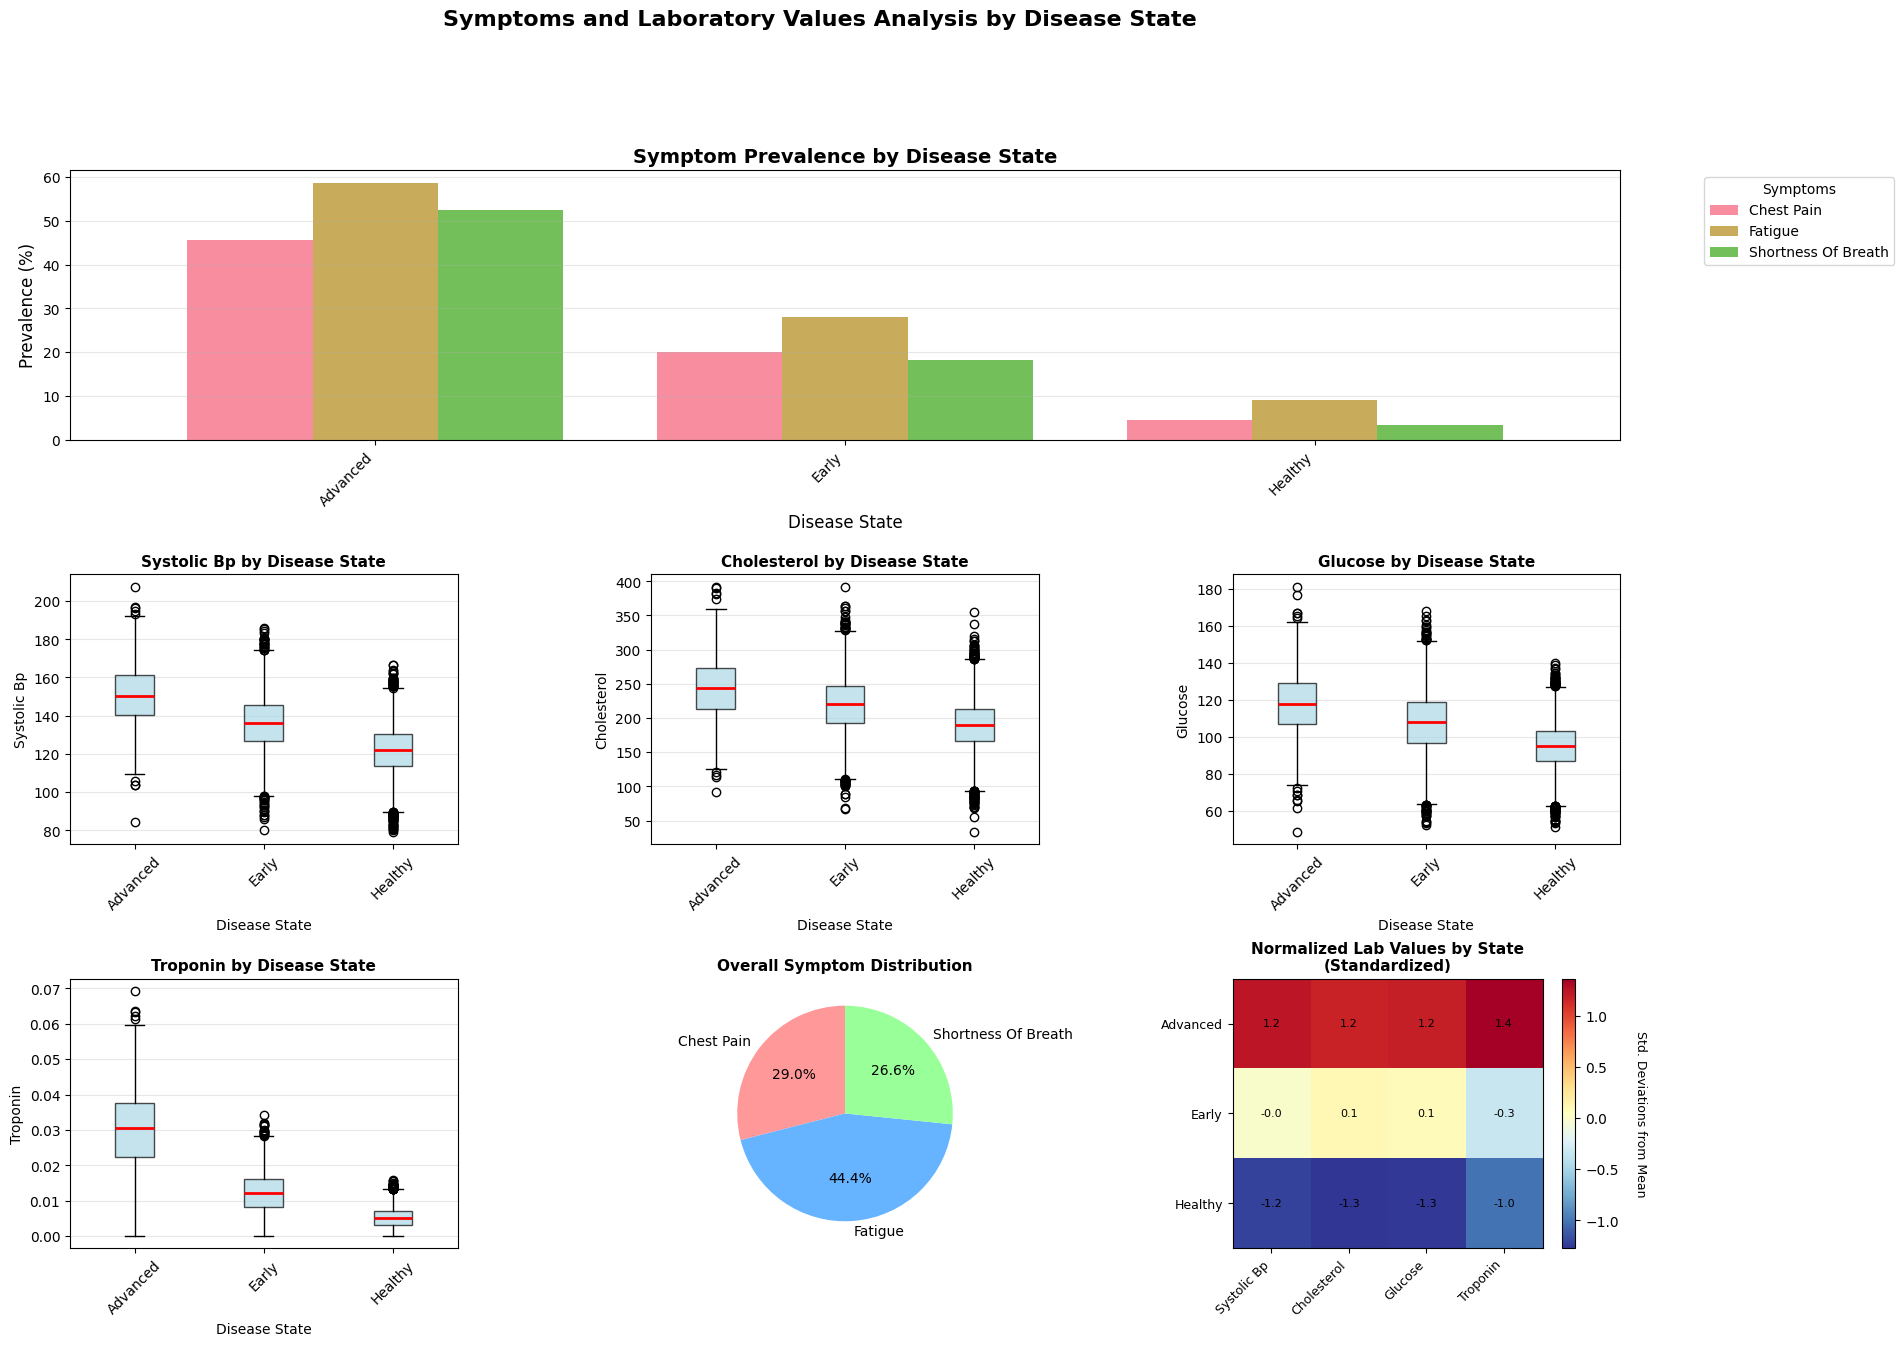

In [ ]:
# ============================================================================
# VISUALIZATIONS
# ============================================================================


# Create comprehensive visualization
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.5, wspace=0.5)

# 1. Symptom frequencies by state
ax1 = fig.add_subplot(gs[0, :])
symptom_by_state = pd.DataFrame()
for symptom in binary_symptoms:
    for state in disease_states:
        state_data = encounters_df[encounters_df['state'] == state]
        percentage = (state_data[symptom].sum() / len(state_data)) * 100
        symptom_by_state.loc[state, symptom.replace('_', ' ').title()] = percentage

symptom_by_state.plot(kind='bar', ax=ax1, width=0.8, alpha=0.8)
ax1.set_xlabel('Disease State', fontsize=12)
ax1.set_ylabel('Prevalence (%)', fontsize=12)
ax1.set_title('Symptom Prevalence by Disease State', fontsize=14, fontweight='bold')
ax1.legend(title='Symptoms', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# 2-5. Lab values by state - box plots
lab_axes = [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]),
            fig.add_subplot(gs[1, 2]), fig.add_subplot(gs[2, 0])]

for idx, (lab, ax) in enumerate(zip(lab_values, lab_axes)):
    lab_data = []
    labels = []
    for state in disease_states:
        state_data = encounters_df[encounters_df['state'] == state][lab].dropna().values
        if len(state_data) > 0:  # Only add non-empty groups
            lab_data.append(state_data)
            labels.append(state)

    bp = ax.boxplot(lab_data, labels=labels, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2))

    lab_name = lab.replace('_', ' ').title()
    ax.set_xlabel('Disease State', fontsize=10)
    ax.set_ylabel(lab_name, fontsize=10)
    ax.set_title(f'{lab_name} by Disease State', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=45)

# 6. Overall symptom prevalence (pie chart)
ax5 = fig.add_subplot(gs[2, 1])
symptom_totals = [symptom_freq[s]['count'] for s in binary_symptoms]
symptom_labels = [s.replace('_', ' ').title() for s in binary_symptoms]
ax5.pie(symptom_totals, labels=symptom_labels, autopct='%1.1f%%', startangle=90,
        colors=['#ff9999', '#66b3ff', '#99ff99'])
ax5.set_title('Overall Symptom Distribution', fontsize=11, fontweight='bold')

# 7. Heatmap of lab values by state (normalized)
ax6 = fig.add_subplot(gs[2, 2])

# Build the dataframe properly
lab_by_state_dict = {}
for state in disease_states:
    lab_by_state_dict[state] = {}
    for lab in lab_values:
        state_mean = encounters_df[encounters_df['state'] == state][lab].dropna().mean()
        lab_by_state_dict[state][lab.replace('_', ' ').title()] = state_mean

lab_by_state_normalized = pd.DataFrame.from_dict(lab_by_state_dict, orient='index')

# Normalize for better visualization
scaler = StandardScaler()
lab_normalized = pd.DataFrame(
    scaler.fit_transform(lab_by_state_normalized),
    index=lab_by_state_normalized.index,
    columns=lab_by_state_normalized.columns
)

im = ax6.imshow(lab_normalized.values, cmap='RdYlBu_r', aspect='auto')
ax6.set_xticks(range(len(lab_normalized.columns)))
ax6.set_yticks(range(len(lab_normalized.index)))
ax6.set_xticklabels(lab_normalized.columns, rotation=45, ha='right', fontsize=9)
ax6.set_yticklabels(lab_normalized.index, fontsize=9)
ax6.set_title('Normalized Lab Values by State\n(Standardized)', fontsize=11, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax6)
cbar.set_label('Std. Deviations from Mean', rotation=270, labelpad=20, fontsize=9)

# Add text annotations
for i in range(len(lab_normalized.index)):
    for j in range(len(lab_normalized.columns)):
        text = ax6.text(j, i, f'{lab_normalized.values[i, j]:.1f}',
                       ha="center", va="center", color="black", fontsize=8)

plt.suptitle('Symptoms and Laboratory Values Analysis by Disease State',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## Interpretation

### Key Findings

#### 1. Symptom Patterns
All symptoms show clear progression with disease state. Prevalence increases from Healthy → Early disease → Advanced disease, with highly significant differences across states (p < 0.001). This systematic increase validates the clinical relevance of the latent disease state labels.

#### 2. Laboratory Value Trends
All biomarkers elevate with disease progression. Troponin shows particularly strong discrimination between states, which is clinically meaningful as it is a cardiac injury marker. The continuous gradation across states suggests smooth disease progression rather than abrupt transitions.

#### 3. Disease State Validity
Strong statistical separation validates the latent state labels used in this dataset. Observable variables (symptoms and lab values) align well with hidden disease states, providing clear signal-to-noise ratio that is ideal for predictive modeling. The highly significant p-values across all variables confirm these are well-defined clinical constructs.

#### 4. Modeling Implications
- **Hidden Markov Models**: Symptoms and lab values can serve as emission probabilities, with disease states as hidden variables
- **Rich Information**: The combination of binary symptoms and continuous lab values provides complementary information for model building
- **Markovian Assumption**: Disease progression appears state-dependent, supporting the use of Markov models where future states depend only on the current state
- **Bayesian Networks**: The clear dependencies between disease states and observable variables make this dataset suitable for learning conditional probability distributions


##5 Treatments and outcomes


###5.1 Treatment analysis

Treatment counts across all encounters:
treatment
None         13818
DrugA         4669
DrugB         2759
Lifestyle     2754
Name: count, dtype: int64


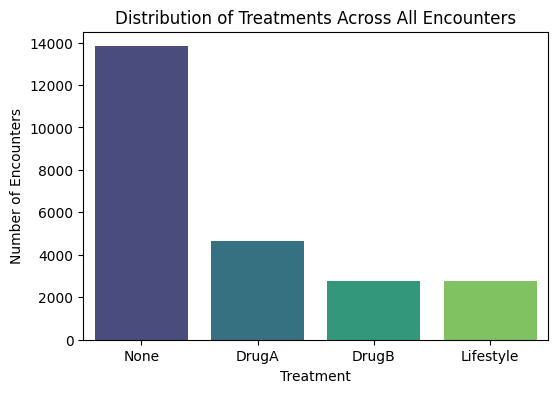

In [ ]:
import pandas as pd

# Assuming your dataframes are called `encounters` and `patients`
# Count occurrences of each treatment
treatment_counts = encounters['treatment'].value_counts()
print("Treatment counts across all encounters:")
print(treatment_counts)

# Bar plot
plt.figure(figsize=(6,4))
sns.barplot(x=treatment_counts.index, y=treatment_counts.values, palette="viridis")
plt.title("Distribution of Treatments Across All Encounters")
plt.xlabel("Treatment")
plt.ylabel("Number of Encounters")
plt.show()


The total counts (as seen in the histogram) clearly show that the "None" option - meaning no treatment - dominates, accounting for the vast majority of encounters. This aligns with the previous observation that most encounters involved patients in the "Healthy" state.

Among the active treatments:

* DrugA is the most commonly administered medication, with 4,669 encounters.

* DrugB and Lifestyle interventions occur at roughly the same frequency, but both are much less common than DrugA.


Treatment distribution by state:
treatment  DrugA  DrugB  Lifestyle   None
state                                    
Advanced     598    576          0      0
Early       3275   2183       1570    627
Healthy      796      0       1184  13191


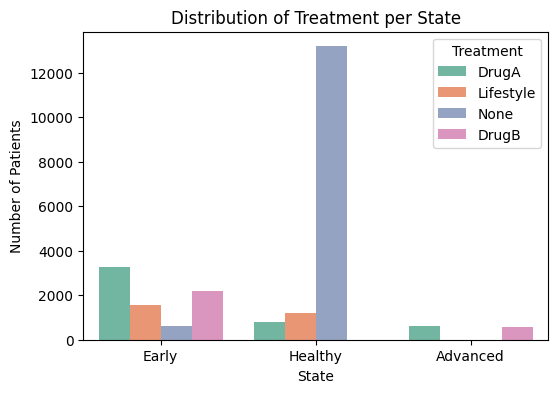

In [ ]:
# Treatment distribution by state
treatment_by_state = pd.crosstab(encounters['state'], encounters['treatment'])
print("\nTreatment distribution by state:")
print(treatment_by_state)

plt.figure(figsize=(6,4))
sns.countplot(data=encounters, x='state', hue='treatment', palette='Set2')
plt.title('Distribution of Treatment per State')
plt.xlabel('State')
plt.ylabel('Number of Patients')
plt.legend(title='Treatment')
plt.show()

This plot provides key insight into the treatment strategies used across different health states.

* Healthy:

Almost all encounters (13191 out of 13818) with “None” as the treatment fall in the Healthy state.

Some healthy patients still receive Lifestyle interventions (1184) and, to a lesser extent, DrugA (796), suggesting these may be used for prevention or for conditions not yet classified as Early.

* Advanced:

Patients in the Advanced state always receive active treatment (no encounters with “None”).

DrugA and DrugB are distributed nearly equally (598 vs. 576).

Lifestyle interventions are never used (0), indicating that pharmacological treatments are preferred at this stage.

* Early:

This state shows the widest variety of treatments.

DrugA is by far the most common (3275), confirming its role as a first-line treatment.

DrugB is the second most common (2183).

Lifestyle interventions peak here (1570).

A small number of Early encounters have “None” as the treatment (627), possibly reflecting periods of observation.

###5.2 Utility analysis

In [ ]:
print(encounters['utility'].describe())


count    24000.000000
mean         0.759256
std          0.319416
min         -0.202000
25%          0.444000
50%          0.982000
75%          1.000000
max          1.000000
Name: utility, dtype: float64


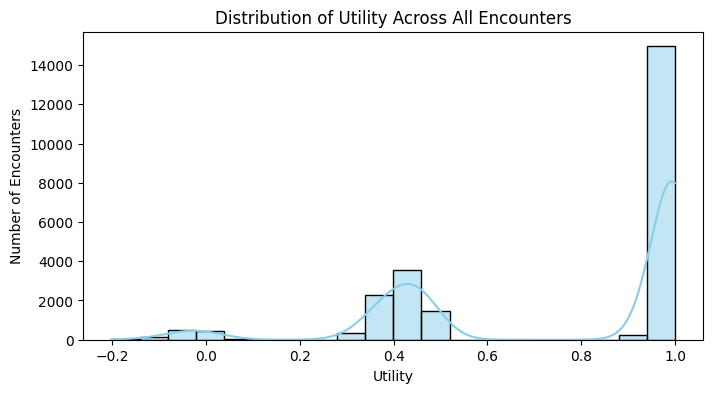

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.histplot(encounters['utility'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Utility Across All Encounters")
plt.xlabel("Utility")
plt.ylabel("Number of Encounters")
plt.show()


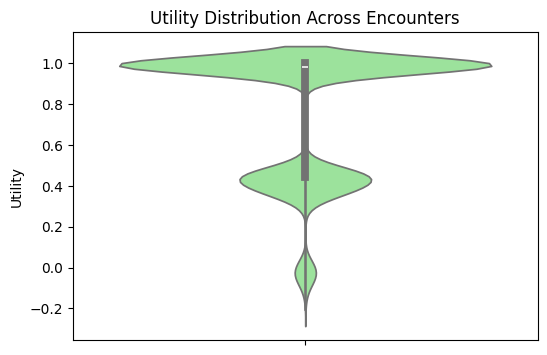

In [ ]:
plt.figure(figsize=(6,4))
sns.violinplot(y=encounters['utility'], color='lightgreen')
plt.title("Utility Distribution Across Encounters")
plt.ylabel("Utility")
plt.show()


Utility is a key metric for assessing perceived or measured health status during each encounter. The maximum value is 1.0, representing perfect utility—the most desirable health state.

The distribution is clearly bimodal and asymmetric:

* Dominant Peak (High Utility):

The largest peak is located near 1.0, at the far right of the histogram.

This indicates that most encounters record near-perfect utility, consistent with earlier analyses showing that most patients are in the "Healthy" state.

* Second Peak (Moderate Utility):

A secondary group of encounters falls around 0.4–0.5.

This likely corresponds to patients in less severe disease states, such as the "Early" stage.

* Low and Negative Utility:

Encounters with very low utility (near 0) or even negative values are rare.

Negative utilities are unusual but signal extremely poor health or states worse than the reference baseline.



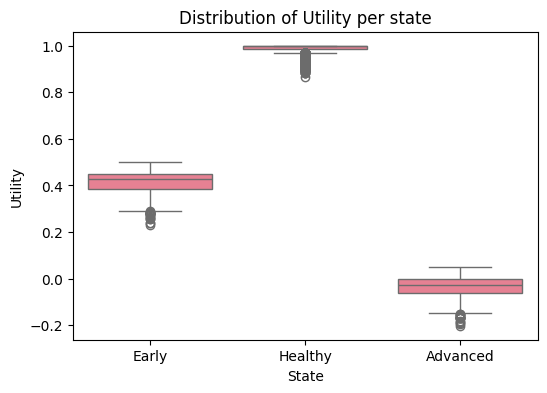

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(data=encounters, x='state', y='utility')
plt.title('Distribution of Utility per state')
plt.xlabel('State')
plt.ylabel('Utility')
plt.show()

The chart clearly confirms a strong separation and consistency between a patient's assigned health state and the recorded utility value, reinforcing the patterns observed in the previous aggregated utility histogram.

1. Healthy State

The median utility is nearly perfect, close to 1.0, the interquartile range is very narrow and sits at the maximum value.

This means that patients in the Healthy state consistently show the highest possible utility, with very little variation. Only a few outliers fall slightly below 1.0.

2. Early State

Utility is concentrated in a moderate range, roughly 0.35–0.5, with a median around 0.4, while the IQR is wider than in the Healthy state, reflecting greater variability in utility scores.

The Early state is clearly distinct from both Healthy and Advanced states, representing a noticeable but manageable reduction in utility.

3. Advanced State

The median utility is very low, around or just below zero.

This state represents severely compromised health or quality of life. The negative utility values seen in the overall distribution are almost entirely associated with the Advanced state.

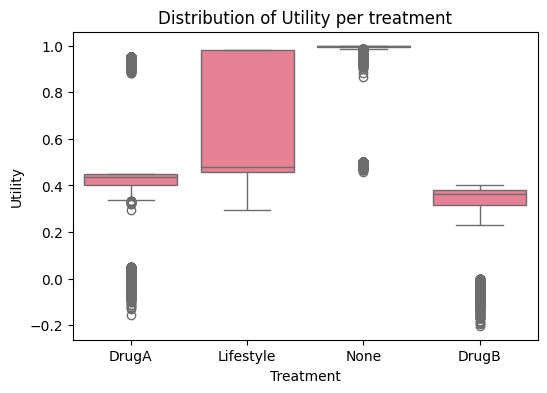

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(data=encounters, x='treatment', y='utility')
plt.title('Distribution of Utility per treatment')
plt.xlabel('Treatment')
plt.ylabel('Utility')
plt.show()

The plot above highlights the relationship between treatment type and recorded utility, showing how different interventions correspond to patients’ health-related quality of life during encounters.

1. Treatment “None”

Utility Value: Utility is almost entirely concentrated at 1.0.

This aligns with previous observations: the “None” treatment is almost exclusively linked to patients in the Healthy state, who exhibit optimal utility.

2. Treatment “Lifestyle”

The distribution is broad, with the interquartile range (IQR) spanning roughly 0.5 to 1.0. The median is around 0.5.

The wide range indicates that Lifestyle interventions are applied to a heterogeneous population.

Lifestyle interventions cover the widest spectrum of utility, reflecting their use both for maintaining health and managing early disease.

3. Treatments “DrugA” and “DrugB”

These medications show narrower and lower distributions, reflecting their primary use in patients with disease (“Early” and “Advanced” stages).

Both drugs are mostly associated with moderate utility, typical of the Early state.

Many outliers (between 0 and −0.2) correspond to patients in the Advanced state, where utility scores are extremely low.

DrugA has a slightly higher and more compressed box than DrugB, suggesting that patients receiving DrugA may have slightly better or less variable utility on average. However, this difference is minimal.

##6 Data quality check

## 6.1 kjbjve

>[M0 - Exploratory Data Analysis (EDA)](#scrollTo=8hhClEAHYVLx)

>>[Dataset Overview](#scrollTo=R6s0ebDNZRCS)

>>[Baseline Characteristics](#scrollTo=DMNx49YNZKfT)

>>>[2.1 For patients.csv](#scrollTo=3h9CiGGAHdkm)

>>>[Observations:](#scrollTo=CnOg1NSMSWEF)

>>>[2.2 For encounters.csv](#scrollTo=09ZUDxNPIe42)

>>>[2.3 Test the normality distribution of the variables](#scrollTo=A8R5otuIJIBT)

>>[3 Disease states](#scrollTo=E8aBdUzsOXk8)

>>>[3.1 Proportion of encounters in each disease state](#scrollTo=d6SS8yUOOcQf)

>>>[3.2 Health progression over time](#scrollTo=tjSvAR-0QCaR)

>>[4 Symptoms and laboratory values](#scrollTo=TYkOpwX40b4i)

>>[Interpretation](#scrollTo=cGGogo2PFx5o)

>>>[Key Findings](#scrollTo=cGGogo2PFx5o)

>>>>[Symptom Patterns](#scrollTo=cGGogo2PFx5o)

>>>>[Laboratory Value Trends](#scrollTo=cGGogo2PFx5o)

>>>>[Disease State Validity](#scrollTo=cGGogo2PFx5o)

>>>>[Modeling Implications](#scrollTo=cGGogo2PFx5o)

>>[5 Treatments and outcomes](#scrollTo=cIAaz0AxrPaf)

>>>[5.1 Treatment analysis](#scrollTo=6dzO2LWmhQG1)

>>>[5.2 Utility analysis](#scrollTo=dIH_25LexF38)

>>[6 Data quality check](#scrollTo=z6eTHU7UhV6l)

>>[6.1 kjbjve](#scrollTo=p_YowxyecTkx)

